# Project 1: Write a data science blogpost

Author: Christoph Wagner
Date: 04/27/2020


## Introduction

This Jupyter notebook contains my solution for project 1 of the Udacity nanodegree "Data Scientist" (project title: "Write a data science blogpost"). The notebook has been created using Jupyther Notebook Server version 6.0.3, running on Python 3.8 (64 bit). 

The project deals with the analysis of an arbitrarily chosen Kaggle dataset with regard to 3-5 self-defined research questions. In my project, I worked with the Stack Overflow Developer Survey 2017 (https://www.kaggle.com/stackoverflow/so-survey-2017).
Within my work, I focused on the preferred work starting time of the developers and its correlation to other features of dataset, e.g. job status, nationality and current salary. 
Specifically, I addressed the following four research questions:
1. How is the preferred work starting time of the survey participants distributed and are there differences between professionals and students
2. Do the preferred starting times of the professionals differ between countries?
3. Is there a correlation between preferred starting time and salary of the employees?
4. Are there correlations between preferred starting time and other selected features?

The relevant data are stored in column "WorkStart". 
Literal question asked to the participants of the survey:
"Suppose you could choose your own working hours for an 8-hour day. What time would you start work for the day? Please adjust the slider to the hour nearest your ideal start time. The box next to the slider will display your selection using a 24-hour clock".

## Importing necessary libraries
Before starting the analysis of the dataset, all the Python libraries necessary for the analysis are imported.

In [1]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

## Gathering the data

Reading in the dataset from the .csv file which was linked at kaggle.com. 
URL: https://www.kaggle.com/stackoverflow/so-survey-2017

In [2]:
#Load dataset
df = pd.read_csv("./survey_results_public.csv")

## Assessing the data

Displaying the most important features of the loaded dataset. 

In [3]:
print(df.shape)
print(df.WorkStart.describe())
print(df.WorkStart.head())

(51392, 154)
count       36696
unique         24
top       9:00 AM
freq         9401
Name: WorkStart, dtype: object
0     6:00 AM
1    10:00 AM
2     9:00 AM
3     9:00 AM
4         NaN
Name: WorkStart, dtype: object


## Cleaning the data

As we are mainly interested in the values of column "WorkStart", drop rows with NAN values. 
Moreover, the values of column "WorkStart" (type "String") are parsed and transformed to a format which is easier to use in the analysis part. 
Specifically, 3 columns are added to the dataset:
* Z_StartingHour: Preferred work starting hour of the employees (integer value in range [0;23]
* Z_StartingNorm: Distance between the preferred starting hour and 9 am, which turned out to be the center of the distribution of preferred starting times (e.g. 8 am = -1, 9 am = 0, 10 am = 1, ...)
* Z_StartingSR: Preferred work starting hour based on 4 am (average start of civil twilight in summer) (i.e. 4 am = 0, 5 am = 1, ..., 3 am = 23)

In [4]:
#Handle NANs
df = df.dropna(subset=["WorkStart"], axis=0)

In [5]:
####################
#Data conversions

#Column Z_StartingHour:
#Converting column WorkStart to integer
def parseTime(str1):
    time=0
    if(str1=="Midnight"):
        time=0
    elif(str1=="Noon"):
        time=12
    else:
        hours=int(str1.split(":")[0])
        suffix=str1.split(" ")[1]
        if(suffix=="AM"):
            time=hours
        else:
            time=hours+12
    return time
df=df.assign(Z_StartingHour=df.WorkStart.apply(parseTime))

#Column Z_StartingNorm:
#Calculating the distance between the preferred starting time and 9 am, 
#which is the center of the distribution of the preferred starting times
#(e.g. 8 am = -1, 9 am = 0, 10 am = 1, ...)
def convertTime1(int1):
    ret=0
    if(4<=int1 and int1<=20):
        ret=int1-9
    else:
        ret=int1-9-24
    return ret
df=df.assign(Z_StartingNorm=df.Z_StartingHour.apply(convertTime1))

#Column Z_StartingSR:
#Calculating the preferred work starting time based on 4 am (average start of civil twilight in summer)
#(e.g. 4 am = 0, 5 am = 1, ..., 3 am = 23)
def convertTime2(int1):
    ret=0
    if(4<=int1):
        ret=int1-4
    else:
        ret=int1-4+24
    return ret
df=df.assign(Z_StartingSR=df.Z_StartingHour.apply(convertTime2))

## Analyze, model and visualize 

### Question 1: Preferred work starting time of the participating professionals and employees

In this part, we adress research question 1: 
How is the preferred work starting time of the survey participants distributed and are there differences
between professionals and students?

First of all, we displayed the overall distribution of preferred work starting times in a histogram. The center of the distribution obviously lies at 9 am and sees to be of Gaussian type. 

Afterwards, we created subsets for employees and students, respecting the employment status (column "Professional"), and compared the distributions. 
The distribution was printed explicitely in % by hour and displayed in a histogram for easier comparison. The histogram shows us that the earlier hours of the morning (6, 7 and 8 am) are more preferred by professionals whereas the the afternoon, evening and night hours are preferred by students as start of the work. 

At last, for the two groups "Employees" and "Students", the average preferred starting hour was calculated for easy comparison. Please note that this statistic doesn't have a real meaning because the value range is circular (e.g. the mean of two participants having preferred starting times 1 am and 11 pm would be 12 am, which is obviously incorrect). Nevertheless, the trend is clear: Professionals prefer earlier starts than participants who still are studying. 

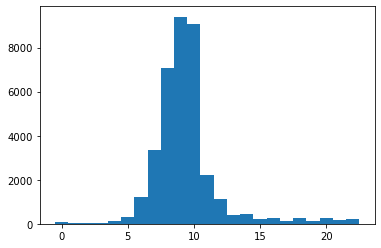

In [6]:
####################
#Question 1: 
#Simply showing the distribution of the preferred work starting time by a histogram

plt.hist(df.Z_StartingHour, bins=np.arange(24)-0.5, histtype="bar")
plt.show()

In [7]:
####################
#Question 1 (cont.): 
#Which answers are possible in the column "Professional"

df.Professional.value_counts()

Professional developer                                  27237
Student                                                  4657
Professional non-developer who sometimes writes code     3507
Used to be a professional developer                       710
None of these                                             585
Name: Professional, dtype: int64

    Professionals  Students
0        0.001887  0.005154
1        0.001171  0.002791
2        0.000846  0.001718
3        0.001203  0.001933
4        0.003155  0.004295
5        0.007384  0.009448
6        0.034283  0.025338
7        0.095498  0.069787
8        0.197112  0.169208
9        0.253090  0.275285
10       0.251203  0.234700
11       0.062516  0.046167
12       0.029990  0.038437
13       0.010474  0.012454
14       0.011319  0.014172
15       0.004879  0.009019
16       0.005530  0.014387
17       0.002960  0.008160
18       0.005822  0.013957
19       0.002797  0.006657
20       0.006310  0.014602
21       0.004001  0.006012
22       0.004684  0.011166
23       0.001887  0.005154

Cumulated responses for range [2 pm; 3 am]:
Professionals    0.054092
Students         0.112948
dtype: float64


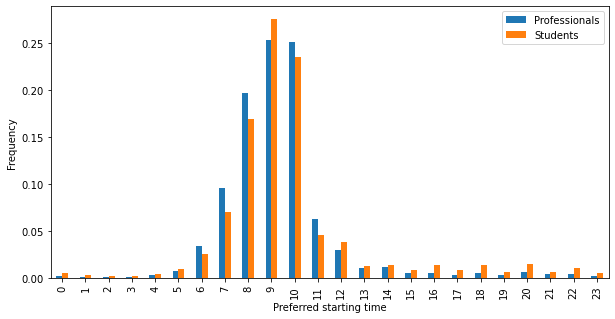

In [8]:
####################
#Question 1 (cont.):
#Dividing the survey participants into two groups: Students and professionals

df_profs=df[df["Professional"].isin(["Professional developer", "Professional non-developer who sometimes writes code"])]
df_studs=df[df["Professional"].isin(["Student"])]

distr_profs=df_profs.Z_StartingHour.value_counts().sort_index()/df_profs.shape[0]
distr_profs=distr_profs.rename("Professionals")
distr_studs=df_studs.Z_StartingHour.value_counts().sort_index()/df_studs.shape[0]
distr_studs=distr_studs.rename("Students")
distr=pd.concat([distr_profs, distr_studs], axis=1)
distr.plot(kind="bar", figsize=(10,5))
plt.xlabel('Preferred starting time',fontsize=10)
plt.ylabel('Frequency',fontsize=10)

print(distr)
print()
print("Cumulated responses for range [2 pm; 3 am]:")
print(distr.iloc[0:3].append(distr.iloc[14:]).sum())

In [9]:
print("Employment status of professionals in %:")
print(df_profs.EmploymentStatus.value_counts()/df_profs.shape[0])
print()
print("Employment status of students in %:")
print(df_studs.EmploymentStatus.value_counts()/df_profs.shape[0])

Employment status of professionals in %:
Employed full-time                                      0.825885
Independent contractor, freelancer, or self-employed    0.106525
Employed part-time                                      0.042317
Not employed, but looking for work                      0.015418
I prefer not to say                                     0.004554
Not employed, and not looking for work                  0.004424
Retired                                                 0.000878
Name: EmploymentStatus, dtype: float64

Employment status of students in %:
Not employed, and not looking for work                  0.043163
Not employed, but looking for work                      0.036658
Employed part-time                                      0.025306
Employed full-time                                      0.021988
Independent contractor, freelancer, or self-employed    0.014865
I prefer not to say                                     0.009335
Retired                               

In [10]:
####################
#Question 1 (cont.):
#Average preferred starting time 

print("Mean of the preferred starting time of professionals: ", round(df_profs.Z_StartingHour.mean(), 2))
print("Mean of the preferred starting time of students: ", round(df_studs.Z_StartingHour.mean(), 2))

Mean of the preferred starting time of professionals:  9.37
Mean of the preferred starting time of students:  9.89


### Question 2: Preferred work starting time by nationality

In the following chapter, we address the second research question: 
Do the preferred starting times of the professionals differ between countries?

First, only the countries (column "Country") with a sufficient number (i.e. more than 100) of survey participants were selected. This selection criterium should assure a minimum objectivity of the analysis, although it doesn't assure representative results. 
The average deviation from the mean of the overall distribution was calculated per country and displayed in a table. By using not the given hour but the deviation from the overall mean (column Z_StartingNorm), we tried to reduce the distortion of the mean caused by the circular value range. The results show clear differences between the single countries. The employees in Iran prefer in average to start their work 45 minutes at 8:15 am, the professionals in Russia almost 2 hours later. 

Later on, the distributions of preferred starting hours are displayed for selected countries in histograms (e.g. for Iran and Russion Federation, which turn out to have maximum deviation of the overall distribution mean). 

Country
Iran                 -0.784753
South Africa         -0.595420
Indonesia            -0.549618
Croatia              -0.526316
Norway               -0.508982
Serbia               -0.507463
Turkey               -0.470968
Slovenia             -0.404040
Mexico               -0.382353
Switzerland          -0.376374
Poland               -0.373626
Sweden               -0.328571
Denmark              -0.292553
New Zealand          -0.275449
Finland              -0.270408
Spain                -0.239006
Australia            -0.177600
Canada               -0.110493
United States        -0.084415
Ireland              -0.012448
Pakistan             -0.005076
Austria               0.019481
Czech Republic        0.019763
India                 0.052222
United Kingdom        0.056773
Italy                 0.068817
Lithuania             0.097345
Germany               0.116121
Belgium               0.148148
Argentina             0.195804
Romania               0.208333
Brazil                0.210638


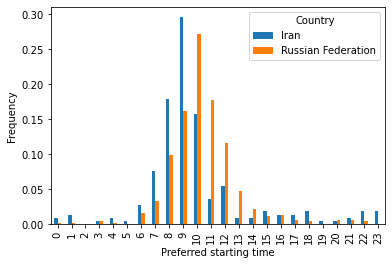

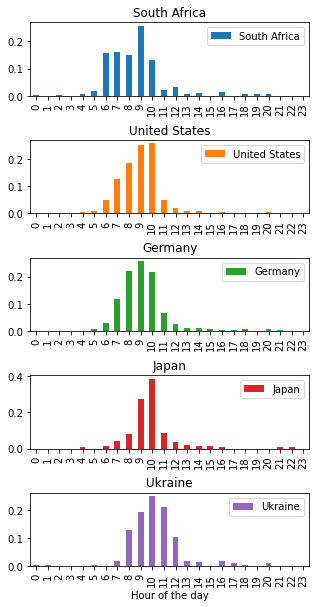

In [11]:
####################
#Question 2: 

#Only respect countries with a sufficient number of participants (here: more than 100)
country_counts=df_profs.Country.value_counts()
signif_countries=country_counts[country_counts>100]
df_profs_relev=df_profs[df_profs["Country"].isin(list(signif_countries.index))]

#What is the average deviation of the pref. starting hour of the survey participants from 9 am (per country)
print(df_profs_relev.groupby("Country")["Z_StartingNorm"].mean().sort_values(ascending=True))

#Display the distribution for the extreme cases: Iran and Russian Federation
distr_extr=df_profs_relev.pivot_table(values="Respondent", index=["Z_StartingHour"], 
                                     columns="Country", fill_value=0, aggfunc=len, margins=True)
distr_extr_perc = distr_extr.div(distr_extr.iloc[-1], axis=1)
distr_extr_perc[["Iran", "Russian Federation"]].iloc[:-1].plot(kind="bar")
plt.xlabel('Preferred starting time',fontsize=10)
plt.ylabel('Frequency',fontsize=10)

#Display the distributions for selected countries
ax=distr_extr_perc[["South Africa", "United States", "Germany", "Japan", "Ukraine"]].iloc[:-1].plot(kind="bar", subplots=True, figsize=(5,10), sharex=False)
ax[0].xaxis.set_label_text("")
ax[1].xaxis.set_label_text("")
ax[2].xaxis.set_label_text("")
ax[3].xaxis.set_label_text("")
ax[4].xaxis.set_label_text("Hour of the day")
plt.subplots_adjust(hspace = 0.6)


In [12]:
distr_extr_perc["Russian Federation"].iloc[10:23].sum()

0.6825095057034221

### Question 3: Correlation between preferred starting time and salary

The third chapter of the analysis and modelling part deals with the following research question:
Is there a correlation between preferred starting time and salary of the employees?

The analysis focuses on the salaries per year of the employees, which are stored in column "Salary" of the dataset. 
First, the average salary per preferred work starting hour is calculated (ignoring NANs implicitly). The data clearly show us that the average salary has its top point in the group of people who want to start at 5 am in the morning (about 68.000 \\$ per year). From then, it almost constantly falls until about 45.000 \\$ per year (group of people who want to start at 12 am). For the groups preferring to start in the afternoon and evening hours, a bigger volatility is visible in the data. This is probably due to the fact that far less people prefer these late hours of the day, thus single outliers have a bigger influence on the average value. Anyway, the trend shows falling salaries until the 11 pm group (aroung 17.000 \\$ per year).

Then the average salaries are plotted in a line plot, starting the x scale at 4 am (average start of civil twilight in summer) to better show the trend. In addition, another plot shows us the distribution of the starting hour preferences in a histogram (for better understanding of the first plot). 


Z_StartingHour
0     22112.37
1     18824.08
2     19501.66
3     29238.15
4     59707.40
5     67672.37
6     64509.87
7     64149.43
8     56558.97
9     56079.31
10    59023.01
11    55335.18
12    45461.51
13    55682.50
14    42609.01
15    58292.05
16    49280.43
17    35972.10
18    39488.29
19    40233.22
20    42208.37
21    40719.48
22    31405.73
23    17260.19
Name: Salary, dtype: float64


Text(0, 0.5, 'Number of respondents')

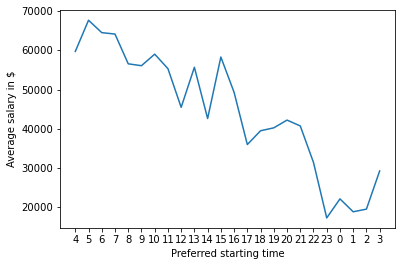

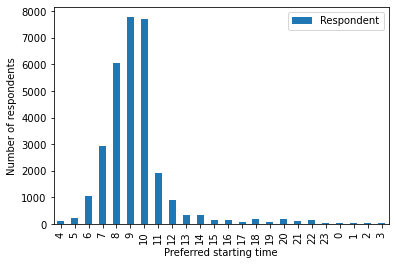

In [13]:
####################
#Question 3: 

#Print average values per starting hour
mean_per_h=round(df_profs.groupby("Z_StartingHour")["Salary"].mean(), 2)
print(mean_per_h)

#Reindex table and plot preferred starting hours against average salary
mean_per_h=mean_per_h.reset_index()
mean_per_h=mean_per_h.assign(Z_Index=mean_per_h.Z_StartingHour.apply(convertTime2))
mean_per_h=mean_per_h.set_index("Z_Index").sort_index()
ax1 = mean_per_h.Salary.plot(xticks=mean_per_h.index)
ax1.set_xticklabels(mean_per_h.Z_StartingHour)
plt.xlabel('Preferred starting time',fontsize=10)
plt.ylabel('Average salary in $',fontsize=10)

#For comparison: Plot again the distribution of preferred starting hours among respondents
ax2=df_profs.groupby("Z_StartingSR")["Respondent"].count().reset_index().plot(x="Z_StartingSR", y="Respondent", kind="bar")
ax2.set_xticklabels(mean_per_h.Z_StartingHour)
plt.xlabel('Preferred starting time',fontsize=10)
plt.ylabel('Number of respondents',fontsize=10)


### Question 4: Other correlations

In the last chapter, we analyzed the following question:
Are there correlations between preferred starting time and other selected features?

First, we searched the columns of the dataset for features which could be related to the preferred starting time of work. 
Found columns:
* AssessJobRemote: Employees with a big affinity to remote work could also favor unusual work starting times, e.g. on compassionate grounds
* HomeRemote: Inversely, people who already mostly work remote could prefer earlier working hours because they don't have to commute.
* AssessJobCommute: Employees who prefer late starting times at work could equally be sensitive to long commuting times because of traffic reasons.

For all mentioned columns, the average preferred starting times per value (also NAN) have been calculated. For better understanding, the values have been sorted by intensity of approval to the asked statement. 
Later on, the values have been plotted in a bar diagram per feature for easier comparison. 
The results don't show us a clear trend, the differences are very small. 
Nevertheless it's visible that
* employees with small interest in remote work prefer to start earlier to work than average
* employees with small sensitivity to long commuting time prefer to start earlier to work than average
* employees which work mostly remote prefer slightly later starting hours than average.


                      Z_StartingNorm
AssessJobRemote                     
Not at all important       -0.073976
Not very important         -0.054677
Somewhat important         -0.023856
Important                  -0.058026
Very important              0.025247
No Answer                   0.011693

                      Z_StartingNorm
AssessJobCommute                    
Not at all important       -0.606250
Not very important          0.067352
Somewhat important         -0.019890
Important                  -0.009273
Very important             -0.047825
No Answer                   0.007431

                                                    Z_StartingNorm
HomeRemote                                                        
Never                                                    -0.022433
It's complicated                                         -0.096797
A few days each month                                     0.025580
Less than half the time, but at least one day e...       -0.034960
Abou

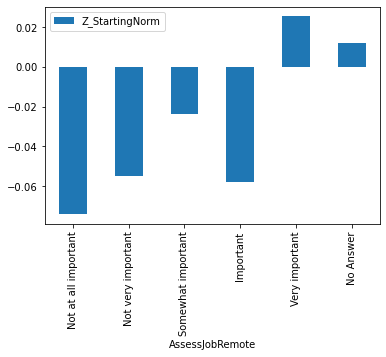

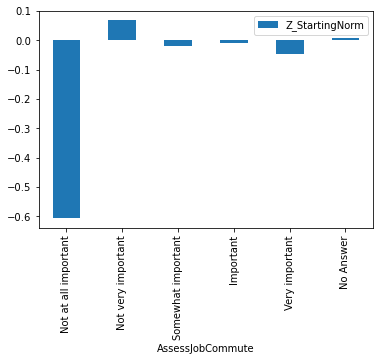

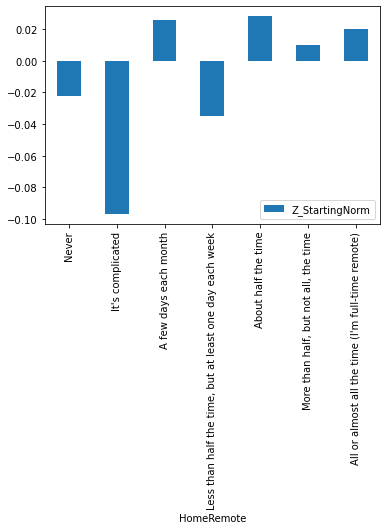

In [14]:
####################
#Question 4: 
#Are there correlations between preferred starting time and other selected features?

#Replace NANs bei explicit text so that it is not discarded automatically
df_profs_f=df_profs.fillna("No Answer")

#Correlation to feature "AssessJobRemote"
df_ajr=df_profs_f.groupby("AssessJobRemote")["Z_StartingNorm"].mean().to_frame()
new_index=[df_ajr.index[2], df_ajr.index[3], df_ajr.index[4], df_ajr.index[0], df_ajr.index[5], df_ajr.index[1]]
df_ajr=df_ajr.reindex(new_index)
print(df_ajr)
df_ajr.plot(kind="bar")
print()

#Correlation to feature "AssessJobCommute"
df_ajc=df_profs_f.groupby("AssessJobCommute")["Z_StartingNorm"].mean().to_frame()
df_ajc=df_ajc.reindex(new_index)
print(df_ajc)
df_ajc.plot(kind="bar")
print()

#Correlation to feature "HomeRemote"
df_hr=df_profs_f.groupby("HomeRemote")["Z_StartingNorm"].mean().to_frame()
new_index2=[df_hr.index[6], df_hr.index[3], df_hr.index[0], df_hr.index[4], df_hr.index[1], df_hr.index[5], df_hr.index[2]]
df_hr=df_hr.reindex(new_index2)
print(df_hr)
df_hr.plot(kind="bar")
print()